In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = 'https://raw.githubusercontent.com/h3ct0rzzz/ml_001/main/checkins.csv'
df = pd.read_csv(url, index_col=0)
print('Размер выборки:', df.shape)
df.head()

Размер выборки: (396634, 5)


,user_id,venue_id,latitude,longitude,created_at
id,,,,,
984222,15824.0,5222.0,38.895112,-77.036366,2012-04-21 17:43:47
984234,44652.0,5222.0,33.800745,-84.410520,2012-04-21 17:43:43
984291,105054.0,5222.0,45.523452,-122.676207,2012-04-21 17:39:22
984318,2146539.0,5222.0,40.764462,-111.904565,2012-04-21 17:35:46
984232,93870.0,380645.0,33.448377,-112.074037,2012-04-21 17:38:18


- `id` &mdash; id наблюдения
- `user_id` &mdash; id пользователя в социальной сетке
- `venue_id` &mdash; id места, где произошёл чекин (рестораны, достопримечательности и тп)
- `latitude, longitude` &mdash; координаты чекина
- `created_at` &mdash; время чекина

Работаем с сэмплом в $100000$ наблюдений.

In [3]:
X_adv = df[['longitude', 'latitude']].sample(100000).values
X_adv

array([[ -96.769923 ,   32.802955 ],
       [ -87.6297982,   41.8781136],
       [-122.3320708,   47.6062095],
       ...,
       [-122.3320708,   47.6062095],
       [-122.2006786,   47.610377 ],
       [ -73.9884556,   40.7329606]])

20 баннеров размещаем около офисов компании. Через Google Maps можно узнать координаты этих офисов.

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

In [4]:
offices = np.array([[-118.188740, 33.751277],[-80.324116, 25.867736], [-0.075479, 51.503016],
                  [4.885084, 52.378894], [117.036146, 39.366487], [151.205134, -33.868457]])

Посмотрим как расположение офисов и чекинов выглядит на картинке и попробуем догадаться, где какой материк.

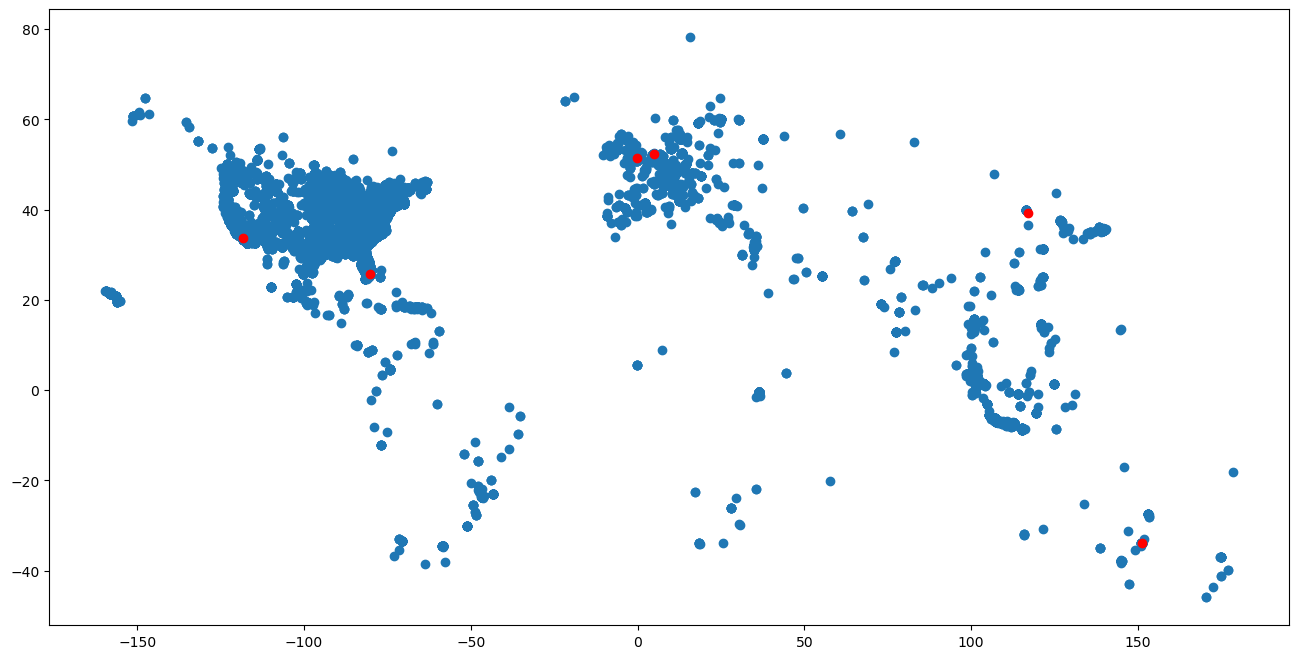

In [5]:
plt.figure(figsize=(16,8))
plt.scatter(X_adv[:,0], X_adv[:,1])
plt.scatter(offices[:,0], offices[:,1], color='red')

Очевидно, что больше всего чекинов приходится на США и Европу. Вероятно, в этих местах как раз и концетрируются основные клиенты круизного агенства. Скорее всего, оптимальные точки для рекламных щитов будут именно в этих регионах.

Начинаем разбивать чекины на однородные группы. Будем делать это с помощью разных алгоритмов кластеризации. При подсчете расстояний будем пренебрегать тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико, чтобы не повлиять на кластеризацию или сортировку.

# K-средних

Шаги:

1. Инициализируем центры кластеров случайно (должно быть задано количество кластеров).
2. Относим точки к соответствующим кластерам (с минимальным расстоянием до их центра).
3. Производится пересчет центров кластеров по формуле центра масс всех точек принадлежащих кластеру.
4. Пункты 2-3 повторяются до тех пор пока центры кластеров перестанут меняться (сильно).

Тестовые (рандом данные):

In [6]:
from sklearn.cluster import KMeans

np.random.seed(123)
X1 = np.random.randn(100,2)
X2 = np.random.randn(100,2) - np.array([10,1])
X3 = np.random.randn(100,2) - np.array([1,10])
X = np.vstack((X1,X2,X3))
y = np.array([1]*100 + [2]*100 + [3]*100)

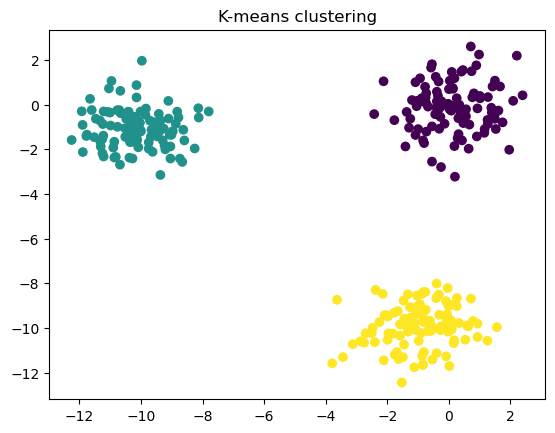

In [7]:
k_means = KMeans(n_clusters = 3)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

plt.scatter(X[:,0], X[:,1], c = clusters)
plt.title('K-means clustering');

Если же не угадали с числом кластеров:

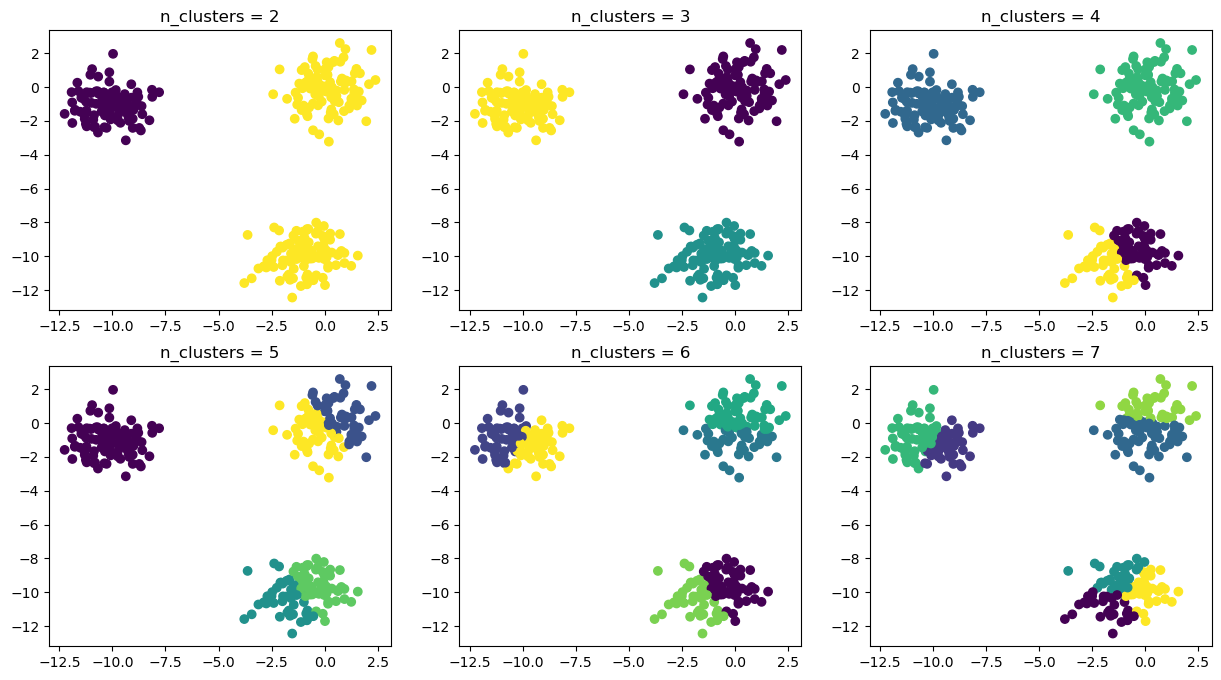

In [8]:
plt.figure(figsize= (15,8))
for n_c in range(2,8):
    k_means = KMeans(n_clusters = n_c)
    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    plt.subplot(2,3, n_c - 1)
    plt.scatter(X[:,0], X[:,1], c = clusters)
    plt.title('n_clusters = {}'.format(n_c))

В случае kMeans распространен критерий – сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся.

$$ 
J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,
$$

здесь $C$ – множество кластеров мощности $K$, $\mu_k$ – центроид кластера $C_k$.

__Здравый смысл в этом есть:__ мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Проблема: минимум такого фнукционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента).

Для решения этого вопроса (выбора числа кластеров) часто пользуются эвристикой: выбираем то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Формально:


$$
Q(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_{k})| } \to \min_{k}
$$






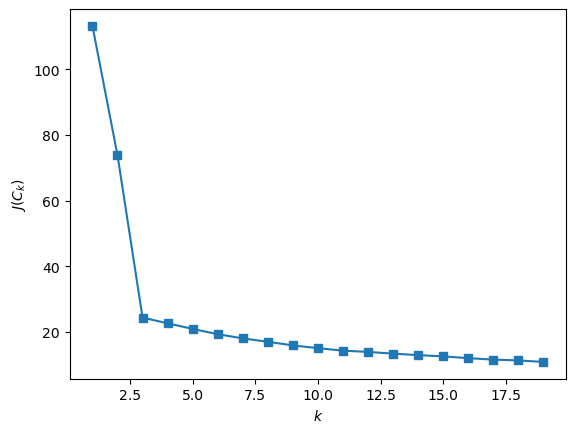

In [9]:
from sklearn import metrics 
from scipy.spatial.distance import cdist

rg = range(1, 20)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Видно, что для нашего примера трёх кластеров достаточно.

__Вернёмся к рекламе.__ Попробуем запустить алгоритм с $50$-ю кластерами.

In [10]:
%%time
from sklearn.cluster import KMeans
kmeanModel = KMeans(n_clusters=50)
kmeanModel.fit(X_adv)

centers = kmeanModel.cluster_centers_ 
labels = kmeanModel.labels_

CPU times: total: 16.3 s
Wall time: 8.29 s


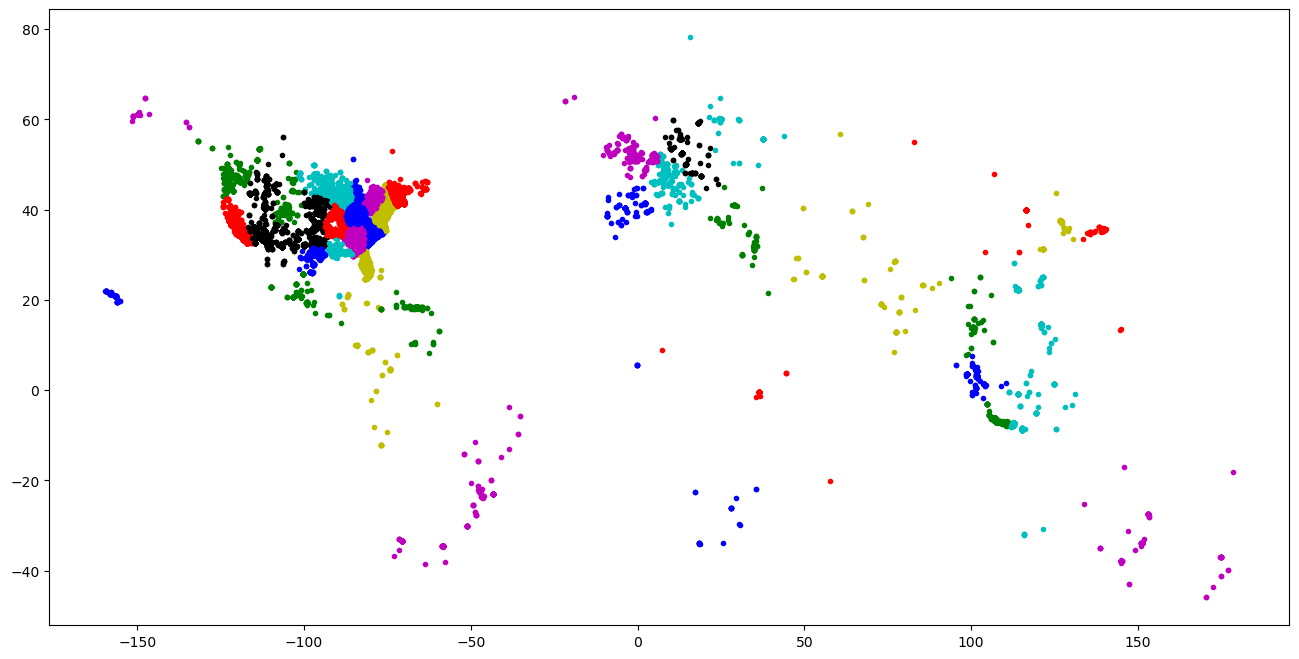

In [11]:
from itertools import cycle

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(figsize=(16,8))

# Будем перебирать все цвета внутри вот этого цикла
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    center = centers[k]
    
    # Каждый кластер наносим на график своим цветом 
    plt.plot(X_adv[my_members,0],X_adv[my_members,1],col + '.' )

Можно попробовать подобрать оптимальное число кластеров методом, который мы рассмотрели выше. Он не даст нам ничего хорошего. Кривая будет плавно убывать при росте числа кластеров.

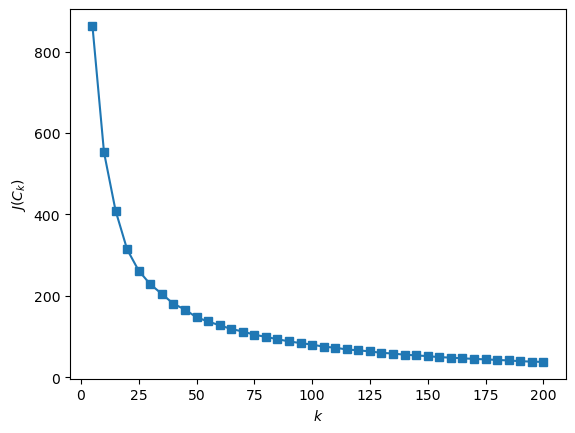

In [12]:
rg = range(5, 205, 5)
inertia = []

X_smpl = X_adv[:10000] # чтобы побыстрее отработало

for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_smpl)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

- Судя по всему, кластеры выстраиваются в соотвествии с границами стран или штатов, это не очень хорошо, непонятно как можно поставить рекламный щит в середине страны. 
- Кластеры оказываются разного размера, а нам хотелось бы, чтобы для каждого банера, по площади, кластеры были одинаковыми, так как хочется одинаковой видимости, а не один банер на всю Францию с непонятно какой видимостью.

__Судя по всему, нужен алгоритм, который формирует кластеры в рамках какой-то заранее заданной окрестности.__

Отдельно отметим, что есть вариация k-medians, которая вместо центров кластеров вычисляет "центроиды", то есть при вычислении центров кластеров использует медиану вместо среднего. Что позволяет алгоритму стать более устойчивым к выбросам.